# The Metagalactic X-ray Background

In this example, we'll compute the Meta-Galactic X-ray background over a series of redshifts ($10 \leq z \leq 40$). To start, the usual imports:

In [1]:
%pylab inline
import ares
import numpy as np
import matplotlib.pyplot as pl
from ares.physics.Constants import c, ev_per_hz, erg_per_ev

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Initialize radiation background
pars = \
{
 # Source properties
 'pop_sfr_model': 'sfrd-func',
 'pop_sfrd': lambda z: 0.1,
 
 'pop_sed': 'pl',
 'pop_alpha': -1.5,
 'pop_Emin': 2e2,
 'pop_Emax': 3e4,
 'pop_EminNorm': 5e2,
 'pop_EmaxNorm': 8e3,
 'pop_rad_yield': 2.6e39,
 'pop_rad_yield_units': 'erg/s/sfr',
 
 # Solution method
 'pop_solve_rte': True,
 'tau_redshift_bins': 400,


 'initial_redshift': 60.,
 'final_redshift': 5.,
}

To summarize these inputs, we've got:

* A constant SFRD of $0.1 \ M_{\odot} \ \mathrm{yr}^{-1} \ \mathrm{cMpc}^{-3}$, given by the ``pop_sfrd`` parameter.
* A power-law spectrum with index $\alpha=-1.5$, given by ``pop_sed`` and ``pop_alpha``, extending from 0.2 keV to 30 keV.
* A yield of $2.6 \times 10^{39} \ \mathrm{erg} \ \mathrm{s}^{-1} \ (M_{\odot} \ \mathrm{yr})^{-1}$ in the $0.5 \leq h\nu / \mathrm{keV} \leq  8$ band, set by ``pop_EminNorm``, ``pop_EmaxNorm``, ``pop_yield``, and ``pop_yield_units``. This is the $L_X-\mathrm{SFR}$ relation found by [Mineo et al. (2012)](http://adsabs.harvard.edu/abs/2012MNRAS.419.2095M).

See the complete listing of parameters relevant to :class:`ares.populations.GalaxyPopulation` objects [here](../params_populations.html).
    
Now, to initialize a calculation and run it:

In [3]:
mgb = ares.simulations.MetaGalacticBackground(**pars)
mgb.run()

We'll pull out the evolution of the background just as we did in the [UV background](example_crb_uv) example:

In [4]:
z, E, flux = mgb.get_history(flatten=True)

and plot up the result (at the final redshift):

Text(0, 0.5, '$J_{\\nu} \\ (\\mathrm{erg} \\ \\mathrm{s}^{-1} \\ \\mathrm{cm}^{-2} \\ \\mathrm{Hz}^{-1} \\ \\mathrm{sr}^{-1})$')

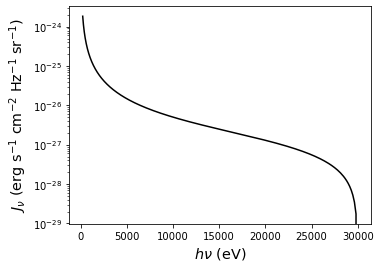

In [5]:
pl.semilogy(E, flux[0] * E * erg_per_ev, color='k')
pl.xlabel(ares.util.labels['E'])
pl.ylabel(ares.util.labels['flux_E'])

Compare to the analytic solution, given by Equation A1 in [Mirocha (2014)](http://adsabs.harvard.edu/abs/2014arXiv1406.4120M>) (the *cosmologically-limited* solution to the radiative transfer equation)

$J_{\nu}(z) = \frac{c}{4\pi} \frac{\epsilon_{\nu}(z)}{H(z)} \frac{(1 + z)^{9/2-(\alpha + \beta)}}{\alpha+\beta-3/2} \times \left[(1 + z_i)^{\alpha+\beta-3/2} - (1 + z)^{\alpha+\beta-3/2}\right]$

with $\alpha = -1.5$, $\beta = 0$, $z=5$, and $z_i=60$,

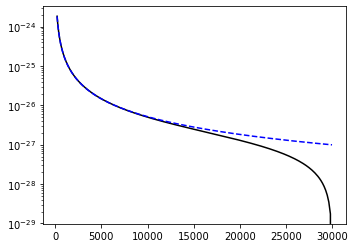

In [6]:
# Grab the GalaxyPopulation instance
pop = mgb.pops[0] 

# Plot the numerical solution again
pl.semilogy(E, flux[0] * E * erg_per_ev, color='k')

# Compute cosmologically-limited solution
e_nu = np.array([pop.Emissivity(10., energy) for energy in E])
e_nu *= c / 4. / np.pi / pop.cosm.HubbleParameter(5.) 
e_nu *= (1. + 5.)**6. / -3.
e_nu *= ((1. + 60.)**-3. - (1. + 5.)**-3.)
e_nu *= ev_per_hz


# Plot it
pl.semilogy(E, e_nu, color='b', ls='--')

## Neutral Absorption by the Diffuse IGM

The calculation above is basically identical to the optically-thin UV background calculations performed in the previous example, at least in the cases where we neglected any sawtooth effects. While there is no modification to the X-ray background due to resonant absorption in the Lyman series (of Hydrogen or Helium II), bound-free absorption by intergalactic hydrogen and helium atoms acts to harden the spectrum. By default, ARES will *not* include these effects.

To "turn on" bound-free absorption in the IGM, modify the dictionary of parameters you've got already:

In [7]:
pars['tau_approx'] = 'neutral'

Now, initialize and run a new calculation:

In [8]:
mgb2 = ares.simulations.MetaGalacticBackground(**pars)
mgb2.run()

# Loaded /Users/jordanmirocha/Dropbox/work/mods/ares/input/optical_depth/optical_depth_planck_TTTEEE_lowl_lowE_best_H_400x862_z_5-60_logE_2.3-4.5.hdf5.


and plot the result on the previous results:

In [9]:
z2, E2, flux2 = mgb2.get_history(flatten=True)

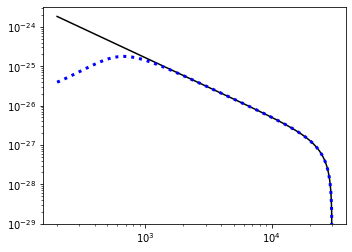

In [10]:
# Plot the numerical solution again
pl.semilogy(E, flux[0] * E * erg_per_ev, color='k')
pl.loglog(E2, flux2[0] * E2 * erg_per_ev, color='b', ls=':', lw=3)

The behavior at low photon energies (:math:`h\nu \lesssim 0.3 \ \mathrm{keV}`) is an artifact that arises due to poor redshift resolution. This is a trade made for speed in solving the cosmological radiative transfer equation, discussed in detail in Section 3 of [Mirocha (2014)](http://adsabs.harvard.edu/abs/2014arXiv1406.4120M>). For more accurate calculations, you must enhance the redshift sampling using the ``tau_redshift_bins`` parameter, e.g.,

In [11]:
pars['tau_redshift_bins'] = 1000

The default optical depth lookup tables that ship with *ARES* use ``tau_redshift_bins=400``, but tables with ``tau_redshift_bins=1000`` are also provided. You can run ``$ARES/input/optical_depth/generate_optical_depth_tables.py`` if you'd like to generate tables with a different resolution.